**<h1><center>Lab-10:Report </center></h1>**

**<h1><center>EE5175: Image Signal Processing </center></h1>**


<h4><center>Under the guidence of </center></h4>
<h4><center>Prof. AN.Rajagopalan </center></h4>

<center>By EE21S048</center>

<h9>Date of submission: 10-04-2022<h9>

---

---
#**Non-local Means Filtering:**

**Import the Libraries:**

In [1]:
from numpy import *
import sys
import cv2
import math
import matplotlib.pyplot as plt
#from imageio import imread
import numpy as np

**Read the Images**

128 128
128 128


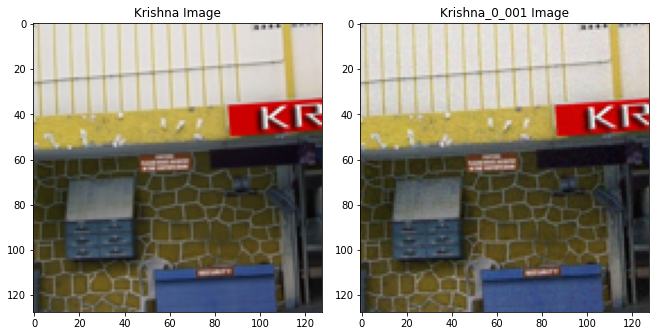

In [2]:
img1= cv2.imread("krishna.png")
width1, height1,z1= img1.shape    
print(width1, height1)

img2= cv2.imread("krishna_0_001.png")
width2,height2,z2= img2.shape  
print(width2, height2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6), constrained_layout=True)
ax1.imshow(img1,'gray')              
ax1.title.set_text("Krishna Image")     
ax2.imshow(img2,'gray')       
ax2.title.set_text("Krishna_0_001 Image")

We are given a noisy image, g (krishna 0 001.png), corresponding to a latent image, f (krishna.png),
corrupted with additive Gaussian noise of mean 0 and variance 0.001. 
* Our task is to apply NLM filtering on g following the steps in the given pseudocode to arrive at the denoised image, $f̂$.
* The parameters of the algorithm are the search neighbourhood radius $W$ , the similarity neighbourhood radius $W_{sim}$ and the filter parameter $σ_{NLM}$ . 

* A radius of W at a pixel denotes a window size
of (2W + 1) × (2W + 1) around that pixel. The same applies to Wsim.

**Q1. Show plots between the PSNR between f and ˆf (y-axis) for different NLM filter parameter
values $σ_{NLM}$ = 0.1 to 0.5 in steps of 0.1 (x-axis) for the following search radius and similarity radius
settings:
(a) $W$= 3, $W_{sim}$ = 3,
(b) $W$ = 5, $W_{sim}$ = 3.**

##**PSNR:**
* Calculate the PSNR between a noisy image and its underlying latent image. PSNR in decibels (dB) is defined as 

$$
20log_{10}\left(\frac{MAX_{f}}{\sqrt{MSE}}\right)
$$

* $MAX_{f}$ is the maximum intensity value in the underlying image and $MSE$ is the mean-squared error between the noisy image and the underlying image. If the $MSE$ is zero, return a really high but finite value to prevent division by zero errors.

In [3]:
def PSNR(latent_image, noisy_image):
    mse = mean((noisy_image-latent_image)**2)
    if mse > 0:
        return 20*log10(np.max(latent_image)/np.sqrt(mse))
    else:
        return float128('2e315')

##**Intensity Gaussian:**
* Given an image patch $\mathcal{N}_{p}$ around a pixel $p$, the weight $w_{pq}$ another patch $\mathcal{N}_{q}$ around a pixel $q$ gets during NLM filtering depends on the forbenius norm of the difference between $\mathcal{N}_{p}$ and $\mathcal{N}_{q}$.

$$
w_{pq} \propto exp\left[{\frac{\|\mathcal{N}_{p}-\mathcal{N}_{q}\|^{2}_{F}}{2\sigma^{2}}}\right]
$$

* $\sigma$ decides the sensitivity. If $\sigma$ is small, $p$ will get a very low contribution from $q$ even if $\mathcal{N}_{q}$ is slightly different from $\mathcal{N}_{p}$. The reverse happens for large $\sigma$. 

In [4]:
def intensity_gaussian(p, q, sigma):
    if sigma > 0:
        return exp(sum((-1*(p-q)**2)/(2*sigma**2)))
    else:
        if sum(abs(p-q)) == 0:
            return 1
        else:
            return 0

##**NLM Local:**
* Given an image patch $\mathcal{N}_{p}$ of size $(2W_{sim}+1)\times (2W_{sim}+1)$ around a pixel $p$, calculate the filtered image intensity at $p, g(p)$. 
$$
g(p) = \frac{1}{Z_{p}}\Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})f(q)
$$
* $G_{p}$ is a neighborhood of size $(2W+1)\times (2W+1)$ around $p$, $G_{\sigma}$ is the Gaussian intensity weight for a given $\sigma$ as defined in the previous section, and, $f(q)$ is the image intensity at pixel $q$. $Z_{p}$ is a normalizing constant given by

$$
Z_{p} = \Sigma_{q\in G_{p}}G_{\sigma}(\mathcal{N}_{p}-\mathcal{N}_{q})
$$

* This ensures that we do not brighten or darken the image while filtering.

In [5]:
def NLM_local(impatch, surroundings, d, W_sim, sigma, return_kernel=False):

    weights = zeros((2*d+1 - 2*W_sim, 2*d+1 - 2*W_sim))      # create a weight matrix of the required size. It is to be noted
                                                                # here that the d input is the sum W + W_sim and hence, W_sim is 
                                                                # subtracted whenever required 
    filtered_val = 0
    for i in range(W_sim, 2*d+1 - W_sim):
        for j in range(W_sim, 2*d+1 - W_sim):
            q = surroundings[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]              # get the patch around another pixel of the size (2*W_sim+1, 2*W_sim+1)
            weights[i-W_sim, j-W_sim] = intensity_gaussian(impatch, q, sigma)   # get the weights          
            filtered_val += weights[i-W_sim, j-W_sim]*surroundings[i, j]        # increment the filtered value
    if return_kernel:
        return filtered_val/sum(weights), weights/sum(weights)
    else:
        return filtered_val/sum(weights)

##**NLM:**
* Perform non-local means on an RGB image for given values of NLM search neighbourhood radius $W$, the similarity neighbourhood radius $W_{sim}$, and the filter parameter $\sigma_{NLM}$. 
* The filtered intensity at a pixel $p$, $g(p)$, is calculated. Do the same for each pixel in the image. For an RGB image, each channel is filtered independently.

In [6]:
def NLM(image, W, W_sim, sigma):
    x, y, _ = shape(image)    # get the image shape
    pad_size = W+W_sim           # zero pad the image
    padded_image =zeros((x+2*pad_size, y+2*pad_size, 3))
    for i in range(3):
        padded_image[pad_size:-pad_size,pad_size:-pad_size, i] = image[:, :, i]
    d = W + W_sim
    filtered_image =zeros((x, y, 3))
    for channel in range(3):     # for each channel
        padded_image_channel = padded_image[:, :, channel]
        for i in range(d, x+d):
            for j in range(d, y+d):
                impatch = padded_image_channel[i-W_sim:i+W_sim+1, j-W_sim:j+W_sim+1]# get the patch around a pixel of shape (2*W_sim+1, 2*W_sim+1)              
                surroundings = padded_image_channel[i-d:i+d+1, j-d:j+d+1]           # get its surroundings of shape (2*W+1, 2*W+1)
                filtered_image[i-d, j-d, channel] = NLM_local(impatch, surroundings, d, W_sim, sigma) # get the filtered value
    return filtered_image

##**Gaussian Filtering:**
Filter an RGB image for a given $\sigma$ and $w$ as defined in the previous section. For an RGB image, filter each channel independently. 

**Construct the Gaussian Kernel:**

In Discrete approximation:


*   Gaussian Kernel h is defined as :
<center>$h(m,n)=1/(\sqrt{2\pi}\sigma^2)*e^{-(m^2+n^2)/(2\sigma^2)}$</center>

*   We normalise the kernel to make entries sum equal to 1 and define the normalised Gaussian Kernel as:
<center>$h(m,n)=1/(\sqrt{2\pi}σ^2sum)*e^{-(m^2+n^2)/(2\sigma^2)}$</center>

 

*   where 'Sum' is the sum of all the elements of gaussian kernel.
 <center>$sum=\sum_{m,n=-t}^{\ m,n=t} h(m,n) = 1$</center>

##**2D Convolution:** 
In the digital domain, convolution is performed by multiplying and accumulating the instantaneous values of the overlapping samples corresponding to two input signals, one of which is flipped.  
*   We zero pad the image on each side with zeroes of size k_size//2.
*   Because when kernel is applied on the corners of the image, kernel center coincides with the pixel and there are missing values in the image.

*   To encounter these missing values we padd zeros of length (kernel_size/2) on the four sides of the image.


In [7]:
def gaussian_denoising_RGB(image, sigma, w):
    width, height, _ = shape(image)
    k_size=w
    kernel=zeros([k_size,k_size])
    t=k_size//2                                         
    const=1/(2*pi*sigma**2)
    for p in range(k_size):
      for q in range(k_size):
        kernel[p,q]=const*exp((-(p-t)**2-(q-t)**2)/(2*(sigma**2)))     #Building Gaussian blur kernel
    kernel=kernel/sum(kernel) 

    filtered_image = zeros((width, height, 3))

    for channel in range(3):
        img_padded= zeros((width+2*t, height+2*t))
        img_padded[t:-t, t:-t] = image[:, :, channel]             
        op_img=zeros([width,height])                     #op_img is the target or output image
        for x in range(t,width+t):                       #traversing from t to width+t on padded image
          for y in range(t,height+t):                    #traversing from t to height+t on padded image
            op=0                                         #setting sum of output pixel to 0
            for i in range(k_size):                      #traversing through the kernel 
              for j in range(k_size):
                op+=kernel[i,j]*img_padded[x-t+i,y-t+j]  #multiplying and summing up the values
            op_img[x-t,y-t]=op 
        filtered_image[:, :, channel] = op_img
    return filtered_image

##**NLM Filtering:**
* Display the noisy image and results of NML filtering for different values of $\sigma_{NLM}$ and $W$. $W_{sim}$ is taken to be $3$ for all of the cases.

In [8]:
krishna = cv2.imread('krishna.png')/255
krishna_noisy =cv2.imread('krishna_0_001.png')/255

In [11]:
sigma_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
W_sim = 3
W_vals = [3, 5]
gaussian_kernel_size = 7
NLM_data = {}
Gaussian_data = {}
for sigma in sigma_vals:
    gaussian_filtered_image = gaussian_denoising_RGB(krishna_noisy, sigma, gaussian_kernel_size)
    Gaussian_data[sigma] = (gaussian_filtered_image,PSNR(krishna, gaussian_filtered_image))
for sigma in sigma_vals:
    for W in W_vals:
        NLM_filtered_image = NLM(krishna_noisy, W, W_sim, sigma)
        NLM_data[(sigma, W)] = (NLM_filtered_image,PSNR(krishna, NLM_filtered_image))

**W = 3:**

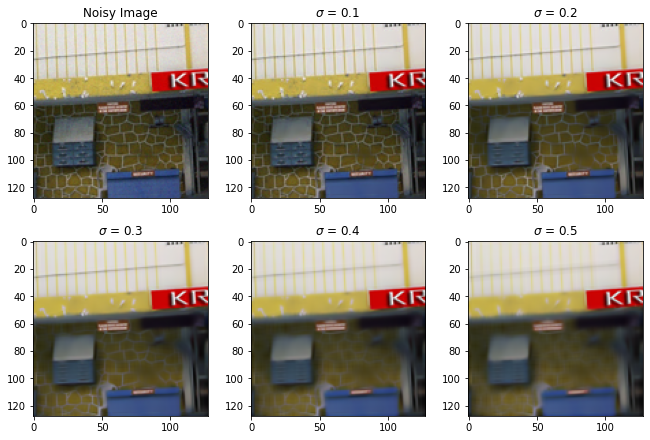

In [20]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(9,6), constrained_layout=True)
ax1.imshow(krishna_noisy)
ax1.title.set_text(rf"Noisy Image")
ax2.imshow(NLM_data[(sigma_vals[0], W_vals[0])][0])
ax2.title.set_text(rf"$\sigma$ = {sigma_vals[0]}")
ax3.imshow(NLM_data[(sigma_vals[1], W_vals[0])][0])
ax3.title.set_text(rf"$\sigma$ = {sigma_vals[1]}")
ax4.imshow(NLM_data[(sigma_vals[2], W_vals[0])][0])
ax4.title.set_text(rf"$\sigma$ = {sigma_vals[2]}")
ax5.imshow(NLM_data[(sigma_vals[3], W_vals[0])][0])
ax5.title.set_text(rf"$\sigma$ = {sigma_vals[3]}")
ax6.imshow(NLM_data[(sigma_vals[4], W_vals[0])][0])
ax6.title.set_text(rf"$\sigma$ = {sigma_vals[4]}")
plt.show()

**W = 5:**

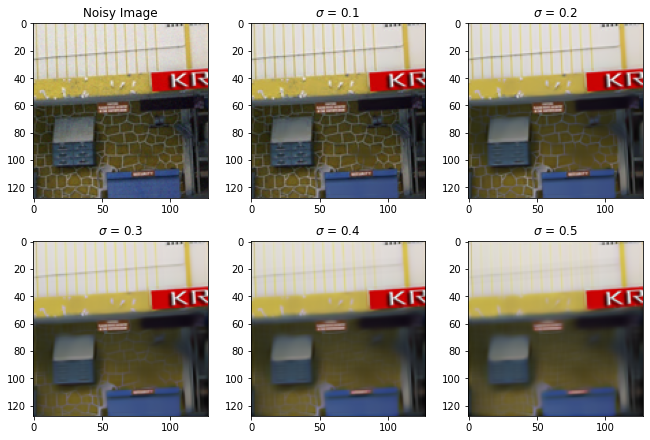

In [21]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,6), constrained_layout=True)
ax1.imshow(krishna_noisy)
ax1.title.set_text(rf"Noisy Image")
ax2.imshow(NLM_data[(sigma_vals[0], W_vals[1])][0])
ax2.title.set_text(rf"$\sigma$ = {sigma_vals[0]}")
ax3.imshow(NLM_data[(sigma_vals[1], W_vals[1])][0])
ax3.title.set_text(rf"$\sigma$ = {sigma_vals[1]}")
ax4.imshow(NLM_data[(sigma_vals[2], W_vals[1])][0])
ax4.title.set_text(rf"$\sigma$ = {sigma_vals[2]}")
ax5.imshow(NLM_data[(sigma_vals[3], W_vals[1])][0])
ax5.title.set_text(rf"$\sigma$ = {sigma_vals[3]}")
ax6.imshow(NLM_data[(sigma_vals[4], W_vals[1])][0])
ax6.title.set_text(rf"$\sigma$ = {sigma_vals[4]}")
plt.show()

**Gaussian Filtering**
* Display the noisy image and results of NML filtering for different values of $\sigma_{g}$. The window size is held constant at $7\times 7$

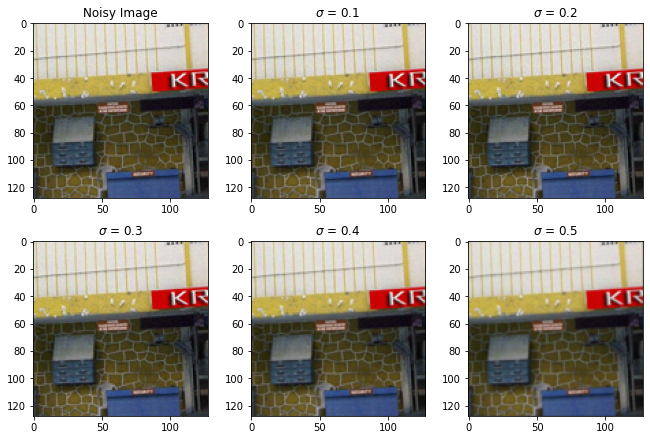

In [22]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,6), constrained_layout=True)
ax1.imshow(krishna_noisy)
ax1.title.set_text(rf"Noisy Image")
ax2.imshow(Gaussian_data[sigma_vals[0]][0])
ax2.title.set_text(rf"$\sigma$ = {sigma_vals[0]}")
ax3.imshow(Gaussian_data[sigma_vals[1]][0])
ax3.title.set_text(rf"$\sigma$ = {sigma_vals[1]}")
ax4.imshow(Gaussian_data[sigma_vals[2]][0])
ax4.title.set_text(rf"$\sigma$ = {sigma_vals[2]}")
ax5.imshow(Gaussian_data[sigma_vals[3]][0])
ax5.title.set_text(rf"$\sigma$ = {sigma_vals[3]}")
ax6.imshow(Gaussian_data[sigma_vals[4]][0])
ax6.title.set_text(rf"$\sigma$ = {sigma_vals[4]}")
plt.show()

Show two plots in the same window with two different colours corresponding to (a) and (b). Compare
the PSNR plots with the baseline PSNR between the noisy image g and the latent image f.


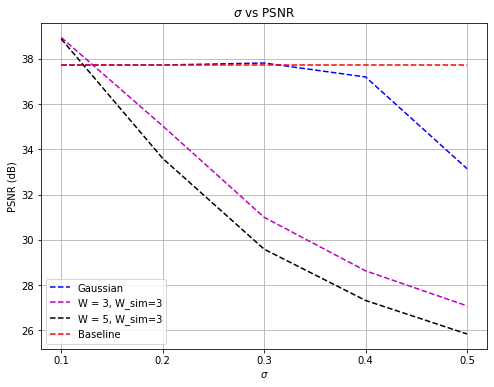

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(sigma_vals, [Gaussian_data[sigma][1] for sigma in sigma_vals],'b--')
plt.plot(sigma_vals, [NLM_data[(sigma, W_vals[0])][1] for sigma in sigma_vals],'m--')
plt.plot(sigma_vals, [NLM_data[(sigma, W_vals[1])][1] for sigma in sigma_vals],'k--')
plt.plot(sigma_vals, [PSNR(krishna, krishna_noisy) for sigma in sigma_vals], 'r--')
plt.xlabel(r"${\sigma}$")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend(["Gaussian", "W = 3, W_sim=3", "W = 5, W_sim=3", "Baseline"])
plt.xticks(sigma_vals)
plt.title(r"$\sigma$ vs PSNR")
plt.show()

##**Display Kernels:**
* Visualize the kernels used in Gaussian and NLM filtering. For Gaussian filtering, a $11\times 11$ kernel with $\sigma_{g}=1$ is used.
* For NLM filtering, we use $\sigma_{NLM}=0.5, W=5, W_{sim}=3$. The resulting $11\times 11$ kernels are shows for the given locations.

#### NLM Kernels
NLM kernels at the different locations are shown

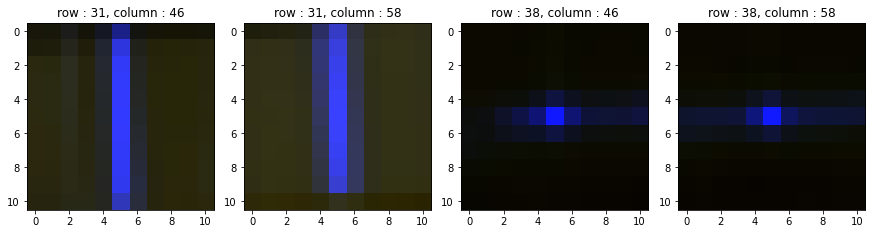

In [19]:
rows = (31, 38)
columns = (46, 58)

image=krishna
row1=rows[0]
column1=columns[0]
row2=rows[1]
column2=columns[1]
W=5
W_sim=3
sigma=0.5

x, y, _ = np.shape(image)
pad_size = W+W_sim
padded_image = np.zeros((x+2*pad_size, y+2*pad_size, 3))
for i in range(3):
    padded_image[pad_size:-pad_size,
                pad_size:-pad_size, i] = image[:, :, i]
d = W+W_sim

k1 = np.zeros((2*W+1, 2*W+1, 3))
k2 = np.zeros((2*W+1, 2*W+1, 3))
k3 = np.zeros((2*W+1, 2*W+1, 3))
k4 = np.zeros((2*W+1, 2*W+1, 3))
for channel in range(3):
    _, k1[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                      padded_image[row1-1:row1+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
    _, k2[:, :, channel] = NLM_local(image[row1-1-W_sim:row1+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                      padded_image[row1-1:row1+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)
    _, k3[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column1-1-W_sim:column1+W_sim, channel],
                                      padded_image[row2-1:row2+2*d, column1-1:column1+2*d, channel], d, W_sim, sigma, return_kernel=True)
    _, k4[:, :, channel] = NLM_local(image[row2-1-W_sim:row2+W_sim, column2-1-W_sim:column2+W_sim, channel],
                                      padded_image[row2-1:row2+2*d, column2-1:column2+2*d, channel], d, W_sim, sigma, return_kernel=True)

# Boost up the kernels before displaying for better visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,9), constrained_layout=True)
ax1.imshow(k1*1/np.max(k1))
ax2.imshow(k2*1/np.max(k2))
ax3.imshow(k3*1/np.max(k3))
ax4.imshow(k4*1/np.max(k4))
ax1.title.set_text(f"row : {row1}, column : {column1}")
ax2.title.set_text(f"row : {row1}, column : {column2}")
ax3.title.set_text(f"row : {row2}, column : {column1}")
ax4.title.set_text(f"row : {row2}, column : {column2}")
plt.show()

In [24]:
def display(image, row1, column1, row2, column2, W=None, W_sim=None, sigma=None, is_kernel=False):   
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,9), constrained_layout=True)
    if not is_kernel:
        if W is not None:
            ax1.imshow(image[row1-W-1:row1+W, column1-W-1:column1+W])
            ax2.imshow(image[row1-W-1:row1+W, column2-W-1:column2+W])
            ax3.imshow(image[row2-W-1:row2+W, column1-W-1:column1+W])
            ax4.imshow(image[row2-W-1:row2+W, column2-W-1:column2+W])
            ax1.title.set_text(f"row : {row1}, column : {column1}")
            ax2.title.set_text(f"row : {row1}, column : {column2}")
            ax3.title.set_text(f"row : {row2}, column : {column1}")
            ax4.title.set_text(f"row : {row2}, column : {column2}")
            plt.show()
    else:
            print("Invalid Inputs")

### Filtering Results
Patches around the given pixels from the noisy and filtered images are shown

#### Noisy Image Patches

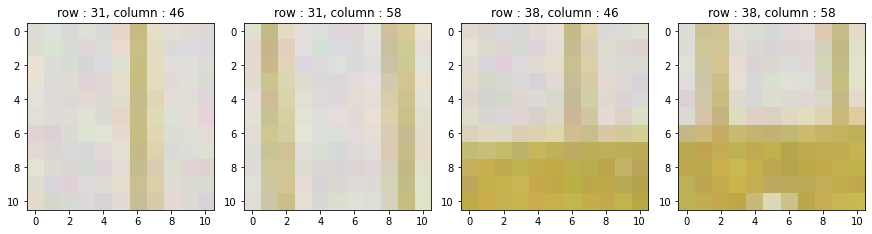

In [25]:
display(krishna_noisy, rows[0], columns[0],rows[1], columns[1], W=5, is_kernel=False)

#### NLM Filtering Results

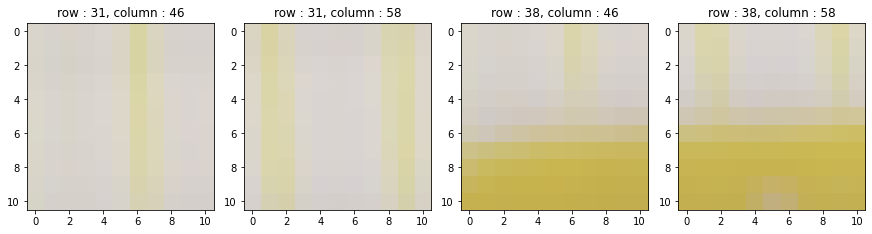

In [26]:
display(NLM_data[(0.5, 5)][0], rows[0], columns[0],rows[1], columns[1], W=5, is_kernel=False)

#### Gaussian Filtering Results

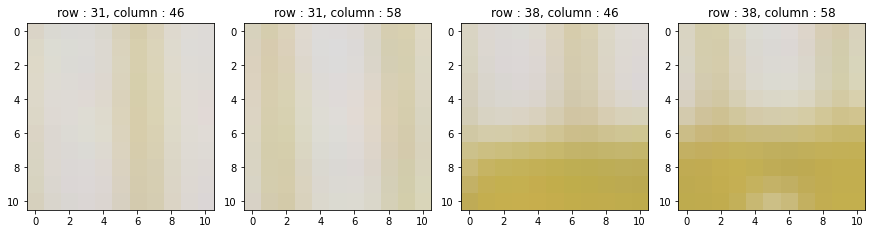

In [27]:
display(gaussian_denoising_RGB(krishna_noisy, sigma=1, w=5),rows[0], columns[0], rows[1], columns[1], W=5, is_kernel=False)

#### NLM Filtering Results (Different Parameters)
Visualize the results for NLM filtering with parameters $\sigma_{NLM}=0.1, W=3, W_{sim}=3$

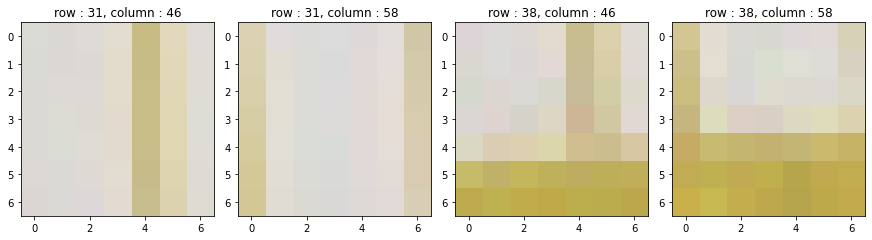

In [28]:
display(NLM_data[(0.1, 5)][0], rows[0], columns[0],rows[1], columns[1], W=3, is_kernel=False)

##**Conclusions:**
* Increasing $\sigma_{g}$ or $\sigma_{NLM}$ deteriorates the performance of the filtering processes. NLM filtering suffers from a lot more blurring than Gaussian filtering on doing this.
* NLM filtering with $\sigma_{NLM}=0.1$ leads to significant noise reduction while maintaining edges. This can be quantified by a higher SNR than the noisy image.
* Gaussian filtering for lower values of $\sigma_{g}$ makes close to no difference to the visual look of the images. This is also reflected in the PSNR value which is very similar to the baseline image.
* The Gaussian kernel is space-invariant and the weight attributed to intensity at another pixel $q$ while calculating the filtered value at a pixel $p$ depends only on the Euclidean norm between $p$ and $q$.
* NLM kernels on the other hand attach a lot of weight only to pixels whose neighborhood is similar to the neighborhood of the pixel under consideration.
* For higher values of $\sigma_{NLM}$, NLM filtering performance is worse for larger values of $W$. This is reflected in the PSNR values.
* A better visiualization is obtained for NLM filtering with parameters $\sigma_{NLM}=0.1, W_{sim}=3$. Beyond this $\sigma_{NLM}$, the sharpness lost makes the image much worse than the slight improvements obtained in noise levels.
---
